# Imports

In [ ]:
%%capture
! pip install catboost
! git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [ ]:
import pandas as pd
import numpy as np
import torch
import time
import tensorflow as tf
import lightgbm as lgb
from datetime import datetime
#from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import *
import time 

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [ ]:
train_df = pd.read_csv("training.csv")
test_df = pd.read_csv("testing.csv")

In [ ]:
train_df.head(4)

,id,time,name,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,target
0,1,2018-05-04T08:12:00Z,BTCUSDT,9727.90,9750.00,9727.90,9745.56,52.08668,507447.897326,454,39.258336,382501.194936,0.005881
1,2,2018-05-04T08:12:00Z,ETHUSDT,789.08,791.00,789.08,790.93,407.54477,322084.533567,379,303.069270,239530.381621,0.004171
2,3,2018-05-04T08:12:00Z,LTCUSDT,160.70,161.36,160.52,161.06,208.47051,33554.990241,76,193.770360,31190.987887,0.010191
3,4,2018-05-04T08:12:00Z,XRPUSDT,0.50,0.50,0.50,0.50,109.51000,54.755000,1,0.000000,0.000000,0.252573


In [ ]:
test_df.head(4)

,id,time,name,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,4892866,2020-09-02T21:10:00Z,BTCUSDT,11352.67000,11353.73000,11351.93000,11353.11000,13.26513,150597.999749,271,7.588199,86148.782015
1,4892867,2020-09-02T21:10:00Z,ETHUSDT,435.35000,435.50000,435.33000,435.48000,190.80991,83072.749754,92,117.808540,51290.913562
2,4892868,2020-09-02T21:10:00Z,LTCUSDT,58.04000,58.05000,58.02000,58.04000,147.65286,8568.443700,38,58.481850,3394.302667
3,4892869,2020-09-02T21:10:00Z,XRPUSDT,0.27583,0.27584,0.27582,0.27582,12764.50000,3520.818389,14,10348.700000,2854.446386


# EDA

## Clean data

Clean up data, since there are multiple rows with the same column values (time, open, high, etc.)

In [ ]:
#Find unclean data
df = train_df
df_grouped = train_df.groupby('time').count()['name']
df_grouped[df_grouped != 4]

time
2018-05-04T19:21:00Z        5
2018-06-26T14:01:00Z        8
2018-06-27T23:21:00Z        8
2018-07-04T00:22:25.552Z    1
2018-07-04T00:22:25.563Z    1
2018-07-04T00:22:27.435Z    1
2018-07-04T00:22:28.668Z    1
2018-07-04T22:01:00Z        8
2018-10-19T20:41:00Z        8
2018-11-14T13:21:00Z        8
2019-03-12T14:41:00Z        8
2019-05-16T04:41:00Z        8
2019-06-07T21:13:13.525Z    1
2019-06-07T21:13:13.541Z    1
2019-06-07T21:13:15.909Z    1
2019-06-07T21:13:17.332Z    1
2019-06-08T02:41:00Z        8
2019-08-15T20:41:00Z        8
2019-11-13T10:41:00Z        8
2019-11-25T06:01:00Z        8
2020-02-09T15:21:00Z        8
2020-02-19T11:35:32.287Z    1
2020-02-19T11:35:32.299Z    1
2020-02-19T11:35:33.983Z    1
2020-02-19T11:35:35.063Z    1
2020-02-20T01:21:00Z        8
2020-03-04T09:21:46.695Z    1
2020-03-04T09:21:46.701Z    1
2020-03-04T09:21:47.642Z    1
2020-03-04T09:21:48.204Z    1
2020-03-04T22:41:00Z        8
2020-04-25T08:01:00Z        8
2020-06-28T22:01:00Z        8
Name:

In [ ]:
#Have a look on unclean data
df[df['time'] == '2018-05-04T19:21:00Z']

,id,time,name,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,target
2676,2677,2018-05-04T19:21:00Z,BTCUSDT,9655.000,9660.00000,9653.00000,9653.04000,12.470589,120392.892343,59,3.842205,37098.825939,0.001237
2677,2678,2018-05-04T19:21:00Z,ETHUSDT,775.040,775.80000,775.04000,775.77000,17.786200,13794.861801,66,13.415460,10406.796576,0.002738
2678,2679,2018-05-04T19:21:00Z,LTCUSDT,163.430,163.44000,163.20000,163.20000,15.747340,2572.415100,9,1.516970,247.918728,-0.000670
2679,2680,2018-05-04T19:21:00Z,XRPUSDT,0.886,0.88768,0.88511,0.88511,49742.440000,44070.016723,25,25.890000,22.982033,0.001712
2680,2681,2018-05-04T19:21:00Z,XRPUSDT,0.886,0.88768,0.88511,0.88511,49742.440000,44070.016723,25,25.890000,22.982033,0.002591


In [ ]:
train_df.drop(train_df[(train_df.time.str.len() != 20)].index, inplace=True)
train_df.drop_duplicates(subset=['time', 'name', 'High', 'Low'], inplace=True)
train_df.reset_index(drop=True, inplace=True)

df_grouped = train_df.groupby('time').count()['name']
print(df_grouped[df_grouped != 4])
del df_grouped

Series([], Name: name, dtype: int64)


## Correlation

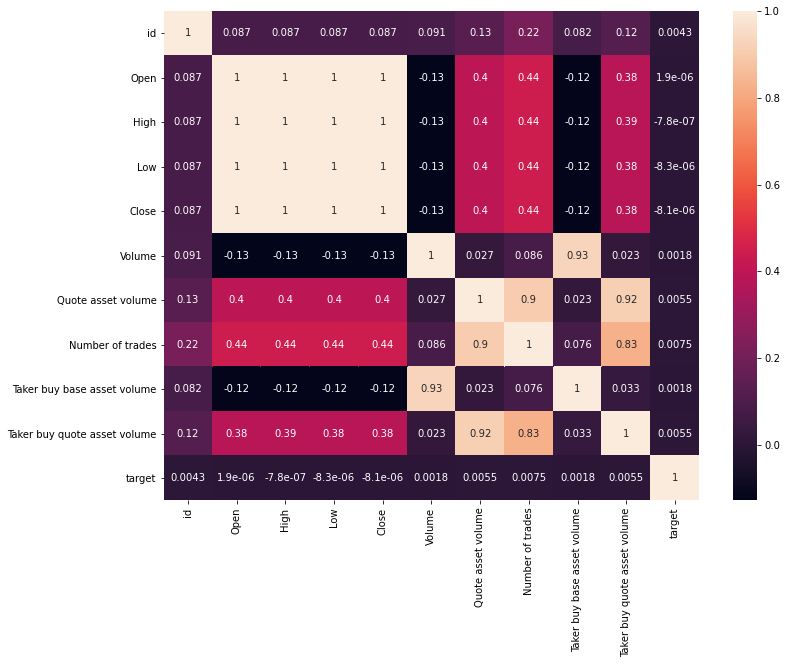

In [ ]:
plt.figure(figsize=(12, 9))
sn.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
#Seperate each crypto
df_BTC = df.loc[df.name == 'BTCUSDT'].copy()
df_ETH = df.loc[df.name == 'ETHUSDT'].copy()
df_LTC = df.loc[df.name == 'LTCUSDT'].copy()
df_XRP = df.loc[df.name == 'XRPUSDT'].copy()

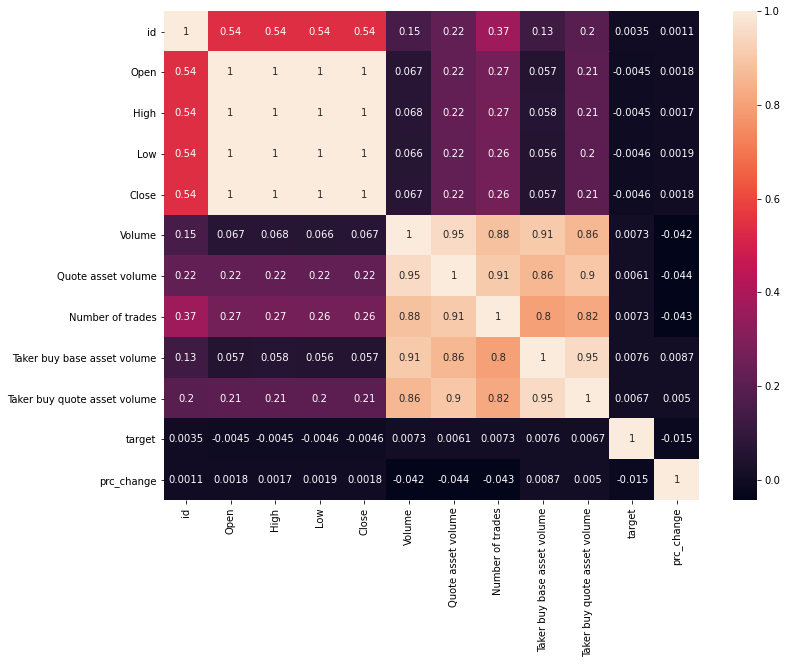

In [ ]:
plt.figure(figsize=(12, 9))
sn.heatmap(df_BTC.corr(), annot=True)
plt.show()

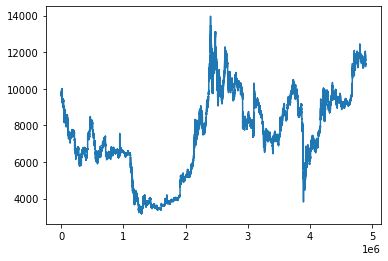

In [ ]:
#Show the trend of opening
plt.plot(df_BTC.index, df_BTC.Open)

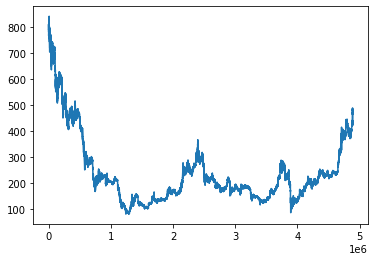

In [ ]:
plt.plot(df_ETH.index , df_ETH.Open)

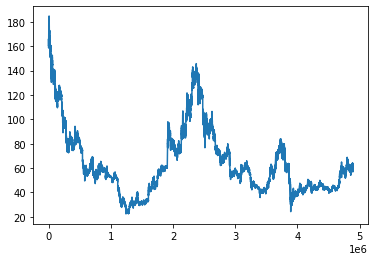

In [ ]:
plt.plot(df_LTC.index , df_LTC.Open)

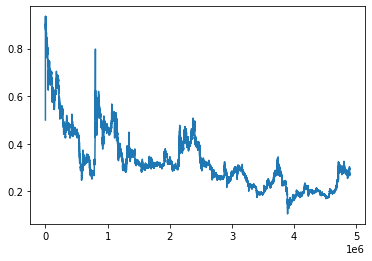

In [ ]:
plt.plot(df_XRP.index , df_XRP.Open)

In [ ]:
# Correlation
df_corr = pd.DataFrame()
df_corr['BTC'] = df_BTC.reset_index()['Open']
df_corr['ETH'] = df_ETH.reset_index()['Open']
df_corr['LTC'] = df_LTC.reset_index()['Open']
df_corr['XRP'] = df_XRP.reset_index()['Open']

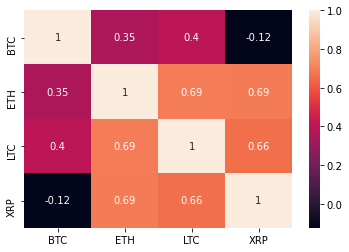

In [ ]:
sn.heatmap(df_corr.corr(), annot=True)
plt.show()

## BTC

### Target

In [ ]:
df_BTC.target.describe()

count    1.223196e+06
mean     1.231460e-06
std      3.161616e-03
min     -1.970404e-01
25%     -1.033108e-03
50%      1.212983e-05
75%      1.059476e-03
max      2.104344e-01
Name: target, dtype: float64

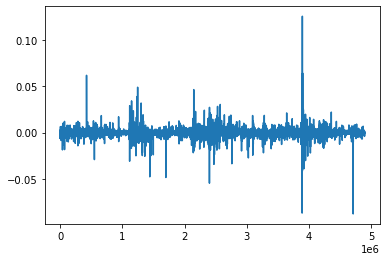

In [ ]:
plt.plot(df_BTC.index[::60], df_BTC.target[::60])

### Opening price

(array([182339.,  50428., 102508., 263534., 174077., 222323., 127043.,
         76879.,  22757.,   1328.]),
 array([ 3157.69 ,  4238.321,  5318.952,  6399.583,  7480.214,  8560.845,
         9641.476, 10722.107, 11802.738, 12883.369, 13964.   ]),
 <a list of 10 Patch objects>)

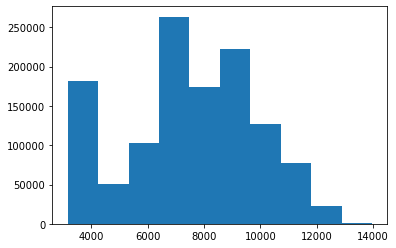

In [ ]:
plt.hist(df_BTC.Open)

In [ ]:
def adf(df):
    X = df[1::60]
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
adf(df_BTC.Open)

ADF Statistic: -1.442851
p-value: 0.561569
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is large, we cannot reject the null hypothesis that there is a unit root. \
The time series is non stationary. 

In [ ]:
# Percentage change
df_BTC['prc_change'] = 0
df_BTC['prc_change'][1:] = np.diff(np.log(df_BTC['Open']))

<ipython-input-41-9bbaf2dc140e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BTC['prc_change'][1:] = np.diff(np.log(df_BTC['Open']))


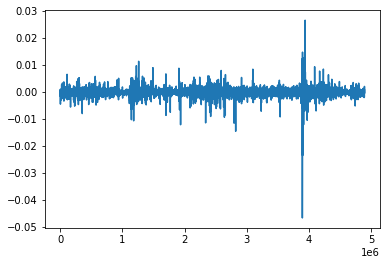

In [ ]:
plt.plot(df_BTC.index[::60], df_BTC.prc_change[::60])

(array([ 268.,  210.,  542., 1812., 7205., 7343., 1925.,  614.,  235.,
         233.]),
 array([-0.003 , -0.0024, -0.0018, -0.0012, -0.0006,  0.    ,  0.0006,
         0.0012,  0.0018,  0.0024,  0.003 ]),
 <a list of 10 Patch objects>)

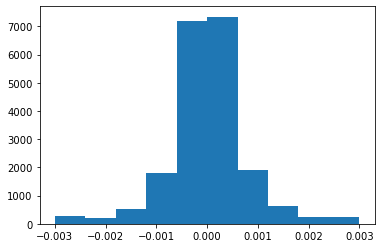

In [ ]:
plt.hist(np.clip(df_BTC.prc_change[::60], -0.003, 0.003))

In [ ]:
adf(df_BTC.prc_change)

ADF Statistic: -20.910557
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

### Volume

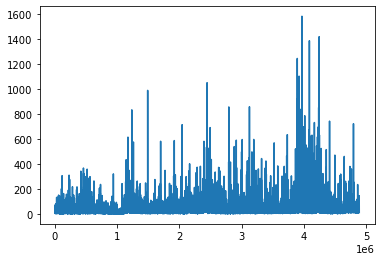

In [ ]:
plt.plot(df_BTC.index[::60], df_BTC.Volume[::60])

(array([10382.,  5331.,  2029.,   993.,   468.,   307.,   212.,   129.,
          107.,   429.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <a list of 10 Patch objects>)

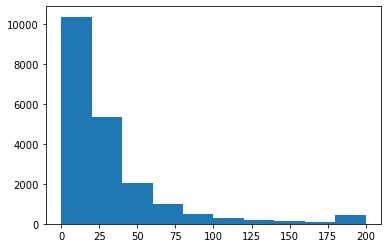

In [ ]:
plt.hist(np.clip(df_BTC.Volume[::60], 0, 200))

In [ ]:
adf(df_BTC.Volume)

ADF Statistic: -11.570529
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

In [ ]:
# Log features
X = np.log(df_BTC.Volume + 1e-8)[1::60] 

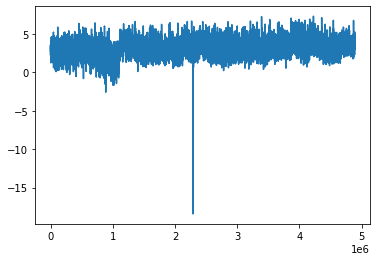

In [ ]:
plt.plot(df_BTC.index[::60], X)

(array([  10.,   39.,  193., 1516., 5885., 7492., 3920., 1078.,  214.,
          40.]),
 array([-2.        , -1.06765293, -0.13530587,  0.7970412 ,  1.72938826,
         2.66173533,  3.59408239,  4.52642946,  5.45877653,  6.39112359,
         7.32347066]),
 <a list of 10 Patch objects>)

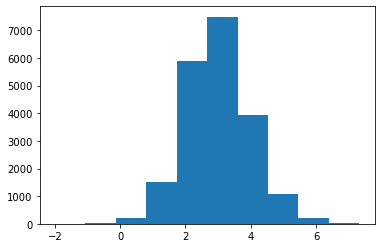

In [ ]:
plt.hist(np.clip(X, -2, 8))

In [ ]:
adf(X)

ADF Statistic: -5.395814
p-value: 0.000003
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

### Quote asset volume

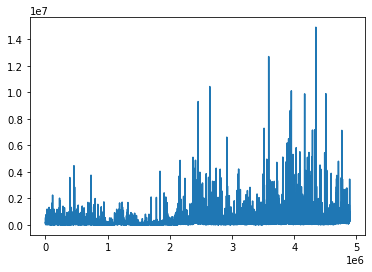

In [ ]:
plt.plot(df_BTC.index[::60], df_BTC['Quote asset volume'][::60])

In [ ]:
adf(df_BTC['Quote asset volume'])

ADF Statistic: -10.377141
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

In [ ]:
# Log features
adf(np.log(df_BTC['Quote asset volume'] + 1e-8))

ADF Statistic: -6.533189
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

### Number of trades

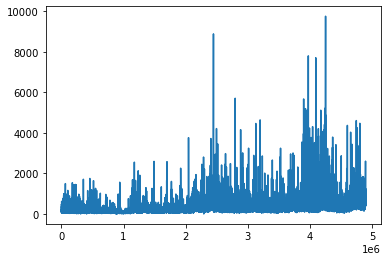

In [ ]:
plt.plot(df_BTC.index[::60], df_BTC['Number of trades'][::60])

In [ ]:
adf(df_BTC['Number of trades'])

ADF Statistic: -7.691617
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
# Log features
adf(np.log(df_BTC['Number of trades'] + 1e-8))

ADF Statistic: -5.592473
p-value: 0.000001
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

### Taker buy base asset volume

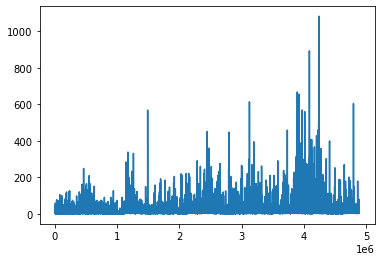

In [ ]:
plt.plot(df_BTC.index[::60], df_BTC['Taker buy base asset volume'][::60])

In [ ]:
adf(df_BTC['Taker buy base asset volume'])

ADF Statistic: -11.921990
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

In [ ]:
adf(np.log(df_BTC['Taker buy base asset volume'] + 1e-8))

ADF Statistic: -9.123486
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p-value is very small, we can reject the null hypothesis that there is a unit root.\
The time series is stationary. 

# Data Preprocessing



In [ ]:
curr_dict = {
    'BTCUSDT': 0,
    'ETHUSDT': 1,
    'LTCUSDT': 2,
    'XRPUSDT': 3
}
train_df = train_df.replace({'name': curr_dict})
test_df = test_df.replace({'name': curr_dict})

In [ ]:
#Make a copy of train and test data before create data time features
train_df_ = train_df.copy()
test_df_ = test_df.copy()

## Date time features

In [ ]:
def get_time_features(df):
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    return df

In [ ]:
train_df = get_time_features(train_df)
test_df = get_time_features(test_df)

## Log features

In [ ]:
def log_diff(col, df):
    df['log_' + col] = 0
    eps = 1e-8
    for i in range(4):
        df['log_' + col][4+i::4] = np.diff(np.log(df[col][i::4] + eps))
    return df

In [ ]:
def log_features(df):
    eps = 1e-8
    df['log_Open'] = np.log(df['Open'] + eps)
    df['log_High'] = np.log(df['High'] + eps)
    df['log_Low'] = np.log(df['Low'] + eps)
    df['log_Close'] = np.log(df['Close'] + eps)
    # df = log_diff('Open', df)
    # df = log_diff('High', df)
    # df = log_diff('Low', df)
    # df = log_diff('Close', df)
    df['log_Volume'] = np.log(df['Volume'] + eps)
    df['log_Quote asset volume'] = np.log(df['Quote asset volume'] + eps)
    df['log_Taker buy base asset volume'] = np.log(df['Taker buy base asset volume'] + eps)
    df['log_Taker buy quote asset volume'] = np.log(df['Taker buy quote asset volume'] + eps)
    return df

In [ ]:
train_df = log_features(train_df)
test_df = log_features(test_df)

In [ ]:
data = train_df[[
                 'name', 'log_Open', 'log_High', 'log_Low', 'log_Close', 
                 'log_Volume', 'log_Quote asset volume', 'log_Taker buy base asset volume',
                 'log_Taker buy quote asset volume', 'Number of trades', 'year',
                 'month', 'day', 'hour', 'minute', 'target'
                ]]

test_data = test_df[[
                     'name', 'log_Open', 'log_High', 'log_Low', 'log_Close', 
                       'log_Volume', 'log_Quote asset volume', 'log_Taker buy base asset volume',
                       'log_Taker buy quote asset volume', 'Number of trades', 'year',
                       'month', 'day', 'hour', 'minute' 
                    ]]

In [ ]:
max_length = len(data)
training_cutoff = int(max_length * 0.95)
train_data = data.iloc[:training_cutoff]
valid_data = data.iloc[training_cutoff:]

In [ ]:
train_data.tail(5)

,name,log_Open,log_High,log_Low,log_Close,log_Volume,log_Quote asset volume,log_Taker buy base asset volume,log_Taker buy quote asset volume,Number of trades,year,month,day,hour,minute,target
4648139,3,-1.622169,-1.622017,-1.622827,-1.622726,10.834326,9.212009,9.612901,7.990520,29,2020,7,22,9,48,0.000008
4648140,0,9.139785,9.139786,9.139596,9.139693,3.310736,12.450412,2.827609,11.967278,497,2020,7,22,9,49,-0.000647
4648141,1,5.492773,5.492856,5.492609,5.492691,5.795107,11.287828,4.005656,9.498368,105,2020,7,22,9,49,-0.000205
4648142,2,3.770229,3.770229,3.769999,3.769999,1.114364,4.884423,1.114364,4.884423,7,2020,7,22,9,49,-0.000225
4648143,3,-1.622624,-1.622624,-1.623030,-1.622726,9.415809,7.792932,7.852284,6.229532,22,2020,7,22,9,49,-0.000075


In [ ]:
valid_data.head(5)

,name,log_Open,log_High,log_Low,log_Close,log_Volume,log_Quote asset volume,log_Taker buy base asset volume,log_Taker buy quote asset volume,Number of trades,year,month,day,hour,minute,target
4648144,0,9.139693,9.139808,9.139305,9.139775,4.778390,13.917844,4.672046,13.811487,569,2020,7,22,9,50,-0.000352
4648145,1,5.492732,5.492773,5.492114,5.492773,6.197024,11.689506,4.927963,10.420436,152,2020,7,22,9,50,0.000041
4648146,2,3.769999,3.769999,3.769307,3.769999,4.088574,7.858338,2.926984,6.696764,17,2020,7,22,9,50,0.000000
4648147,3,-1.622827,-1.622776,-1.623081,-1.622878,10.788839,9.165907,9.606852,7.983942,26,2020,7,22,9,50,-0.000042
4648148,0,9.139774,9.139781,9.139506,9.139674,3.320438,12.460073,2.345568,11.485234,443,2020,7,22,9,51,-0.000123


# Ensemble

In [ ]:
models = {}
random_state = 420

## LightGBM

In [ ]:
models['lgb_gbdt'] = lambda: lgb.LGBMRegressor(
    boosting_type='gbdt', 
    objective="rmse",
    min_child_samples=20,
    num_leaves=40,
    max_depth=16,
    learning_rate=0.005,
    n_estimators=1000,
    colsample_bytree=.4,
    subsample=1.0,
    subsample_freq=0,
    importance_type="gain",
    random_state=random_state,
    n_jobs=-1,
    device='gpu',
)
models['lgb_rf'] = lambda: lgb.LGBMRegressor(
    boosting_type='rf', 
    objective="rmse",
    min_child_samples=20,
    num_leaves=128,
    max_depth=16,
    learning_rate=0.005,
    n_estimators=1000,
    colsample_bytree=.5,
    subsample=.95,
    subsample_freq=20,
    importance_type="gain",
    random_state=random_state,
    n_jobs=-1,
    device='gpu',
)

## CatBoost

In [ ]:
models['cat'] = lambda: CatBoostRegressor(
    task_type='GPU',
    loss_function="RMSE",
    learning_rate=.06,
    max_depth=8,
    min_child_samples=20,
    colsample_bylevel=1.0,
    n_estimators=None,
    use_best_model=True,
    random_seed=random_state,
)

# Training

In [ ]:
def training(model_call, train_X, train_y, valid_X, valid_y, test_X, verbose=False):
    model = model_call()
    if isinstance(model, lgb.LGBMRegressor) or isinstance(model, CatBoostRegressor):
        model.fit(
            train_X,
            train_y,
            eval_set=(
                valid_X, valid_y
            ),
            early_stopping_rounds=100,
            verbose=verbose,
        )
    else: 
        raise NotImplementedError
    
    train_preds = model.predict(train_X)
    valid_preds = model.predict(valid_X)
    test_preds = model.predict(test_X)

    train_rmse = mean_squared_error(train_y, train_preds, squared=False)
    valid_rmse = mean_squared_error(valid_y, valid_preds, squared=False)
    print('train rmse: {}, valid rmse: {}'.format(train_rmse, valid_rmse))
    return model, train_preds, valid_preds, test_preds

In [ ]:
train_y = train_data['target']
train_X = train_data.drop(columns=['target'])

valid_y = valid_data['target']
valid_X = valid_data.drop(columns=['target'])

In [ ]:
results = {}
for key in models:
    start = time.time()
    model, train_preds, valid_preds, test_preds = training(models[key], 
                                                            train_X, train_y, 
                                                            valid_X, valid_y, 
                                                            test_data)
    print("time taken for {}: {}s".format(key, time.time() - start))
    results[key] = {
        'model': model,
        'train_preds': train_preds,
        'valid_preds': valid_preds,
        'test_preds': test_preds,
    }

train rmse: 0.003360518955882364, valid rmse: 0.003151206127885028
time taken for lgb_gbdt: 22.852113485336304s
train rmse: 0.0033292869135981536, valid rmse: 0.003153606696591997
time taken for lgb_rf: 93.08056616783142s
train rmse: 0.0033629078800855115, valid rmse: 0.0031515707755785985
time taken for cat: 6.653825759887695s


## Final linear regression 

In [ ]:
def final_linear(results, train_y, valid_y):
    # fit validation data
    train_preds = pd.DataFrame({key: results[key]['train_preds'] for key in results})
    valid_preds = pd.DataFrame({key: results[key]['valid_preds'] for key in results})
    test_preds = pd.DataFrame({key: results[key]['test_preds'] for key in results})

    lr = LinearRegression()
    lr.fit(valid_preds, valid_y)

    final_train_pred = lr.predict(train_preds)
    final_valid_pred = lr.predict(valid_preds)

    train_rmse = mean_squared_error(train_y, final_train_pred, squared=False)
    valid_rmse = mean_squared_error(valid_y, final_valid_pred, squared=False)
    print('train rmse: {}, valid rmse: {}'.format(train_rmse, valid_rmse))

    out = lr.predict(test_preds)
    return out

In [ ]:
def weighted_avg(results):
    all_test_preds = None
    for key in results:
        if all_test_preds is None:
            all_test_preds = 1./len(results) * results[key]['test_preds']
        else:
            all_test_preds += 1./len(results) * results[key]['test_preds']
    return all_test_preds

In [ ]:
# all_test_preds = weighted_avg(results)
all_test_preds = final_linear(results, train_y, valid_y)

train rmse: 0.0033554841070446238, valid rmse: 0.0031496201228185293


# Output Prediction

In [ ]:
sub_df = test_df[['id']].copy()
sub_df = sub_df.rename(columns={'id': 'Id'})
sub_df['Predicted'] = all_test_preds
sub_df.to_csv("/content/drive/MyDrive/HKUST/MSBD5013/" + 'sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# Xgboost

In [ ]:
xgb_model = xgb.XGBRegressor(
    max_depth = 16,
    learning_rate = 0.05,
    n_estimators = 1000
    )
train_y = train_data['target']
train_X = train_data.drop(columns=['target'])

valid_y = valid_data['target']
valid_X = valid_data.drop(columns=['target'])

test_X = test_data

xgb_model.fit(
        train_X,
        train_y,
        eval_set=[(train_X, train_y), (valid_X, valid_y)],
        early_stopping_rounds=100,
        verbose=True)

train_preds = xgb_model.predict(train_X)
valid_preds = xgb_model.predict(valid_X)
test_preds = xgb_model.predict(test_X)

train_rmse = mean_squared_error(train_y, train_preds, squared=False)
valid_rmse = mean_squared_error(valid_y, valid_preds, squared=False)
print('train rmse: {}, valid rmse: {}'.format(train_rmse, valid_rmse))

sub_df = test_df[['id']].copy()
sub_df = sub_df.rename(columns={'id': 'Id'})
sub_df['Predicted'] = test_preds
sub_df.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

[15:10:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.47539	validation_1-rmse:0.47496
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:0.45104	validation_1-rmse:0.45121


KeyboardInterrupt: 

# VAR

## Dataloader

In [ ]:
test_df_

In [ ]:
#We drop unclean testing set
test_df_.drop(test_df_[test_df_.time == '2020-12-21T14:09:00Z'].index, inplace=True)
test_df_.drop(test_df_[(test_df_.time.str.len() != 20)].index, inplace=True)
test_df_.drop_duplicates(subset=['time', 'name', 'High', 'Low'], inplace=True)

#Make a copy of test data for submittion
sub_df = test_df_.copy()

train_df_ = log_features(train_df_)
test_df_ = log_features(test_df_)

def onehot_col(df):
    #remove non log features
    df.drop(['id', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Quote asset volume', 'Taker buy base asset volume',
        'Taker buy quote asset volume'], axis = 1, inplace = True)

    #Seperate and rename
    temp0 = df[df['name'] == 0]
    temp1 = df[df['name'] == 1]
    temp2 = df[df['name'] == 2]
    temp3 = df[df['name'] == 3]

    rename_list = ['target', 'log_diff_Open',
        'log_diff_High', 'log_diff_Low', 'log_diff_Close', 'log_Volume',
        'log_Quote asset volume', 'log_Taker buy base asset volume',
        'log_Taker buy quote asset volume', 'Number of trades']


    for col in rename_list:
        temp0 = temp0.rename(columns={col: col + '_0'})
        temp1 = temp1.rename(columns={col: col + '_1'})
        temp2 = temp2.rename(columns={col: col + '_2'})
        temp3 = temp3.rename(columns={col: col + '_3'})

    #Merge df
    df_ = temp0.merge(temp1,on='time').merge(temp2,on='time').merge(temp3,on='time')
    df_.drop(['name_x', 'name_y'], axis = 1, inplace = True)

    return df_

data = onehot_col(train_df_)
max_length = len(data)
training_cutoff = int(max_length * 0.9)
train_data = data.iloc[:training_cutoff]
valid_data = data.iloc[training_cutoff:]
test_data = onehot_col(test_df_)

## Model training and testing

In [ ]:
#Training and create submittion file
endog = train_data[['target_0', 'target_1', 'target_2', 'target_3']].astype(float)
exog = train_data.drop(['target_0', 'target_1', 'target_2', 'target_3', 'time'], axis = 1).astype(float)
Var_model = VAR(endog, exog)
results = Var_model.fit()

#Validation
params = valid_data.drop(['target_0', 'target_1', 'target_2', 'target_3', 'time'], axis = 1).astype(float)
valid_preds = results.forecast(endog.to_numpy(), len(params) , exog_future = params)

valid_y = valid_data[['target_0', 'target_1', 'target_2', 'target_3']]
valid_rmse = mean_squared_error(valid_y, valid_preds, squared=False)
print('valid rmse: {}'.format(valid_rmse))

#Testing
df_test_ = test_data.copy()
params = df_test_.drop(['time'], axis = 1).astype(float)
endog = valid_data[['target_0', 'target_1', 'target_2', 'target_3']].astype(float)
VAR_output = results.forecast(endog.to_numpy(), len(params) , exog_future = params)
VAR_sub = pd.DataFrame(VAR_output)

#Create submission file
sub_df = sub_df.rename(columns={'id': 'Id'})
sub_df = sub_df[['Id']]
sub_df['Predicted'] = 0
for i in range(4):
    sub_df.iloc[i::4, 1] = VAR_sub.iloc[:, [i]].values

#Add back unclean rows
for i in range(511805, 511812, 2):
    sub_df.loc[i] = sub_df.loc[i-1]
    sub_df.Id[i] = int(sub_df.Id[i-1]) + 1
for i in range(631596, 631600):
    sub_df.loc[i] = sub_df.loc[i-4]
    sub_df.Id[i] = int(sub_df.Id[i-4]) + 4
sub_df.loc[631684] = [5524550,0]
sub_df.Predicted[631684] = sub_df.Predicted[631683]
for i in range(634886, 634893, 2):
    sub_df.loc[i] = sub_df.loc[i-1]
    sub_df.Id[i] = int(sub_df.Id[i-1]) + 1
for i in range(654650, 654657, 2):
    sub_df.loc[i] = sub_df.loc[i-1]
    sub_df.Id[i] = int(sub_df.Id[i-1]) + 1

#Output file
sub_df.Id = sub_df.Id.astype(int)
sub_df.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

valid rmse: 0.009178308561260715


# Temporal Fusion Transformer

Attempt at using TFT modelling to predict using pytorch forecast library, however, it requires too much memory which is not available to me

In [ ]:
# ! pip install pytorch-forecasting &> /dev/null
# ! pip install pytorch-lightning &> /dev/null

In [ ]:
# import pandas as pd
# import numpy as np
# import torch
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_forecasting.data import GroupNormalizer
# from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
# from pytorch_forecasting.data.encoders import NaNLabelEncoder
# import tensorflow as tf 
# import tensorboard as tb 
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Dataset and Dataloader

In [ ]:
# train_df['time_idx'] = (train_df.index) // 4

In [ ]:
# train_data = train_df[[
#                  'name', 'log_Open', 'log_High', 'log_Low', 'log_Close', 
#                  'log_Volume', 'log_Quote asset volume', 'log_Taker buy base asset volume',
#                  'log_Taker buy quote asset volume', 'Number of trades', 'year',
#                  'month', 'day', 'hour', 'minute', 'target', 'time_idx', 'time'
#                 ]]

In [ ]:
max_length = train_data.time_idx.max()
training_start = int(max_length * 0.6)
training_cutoff = int(max_length * 0.9)
max_prediction_length = int(max_length - training_cutoff)
max_encoder_length = 32

In [ ]:
training = TimeSeriesDataSet(
    train_data[lambda x: (training_start <= x.time_idx) & (x.time_idx <= training_cutoff)], 
    time_idx='time_idx',
    target='target',
    group_ids=['name'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['name'],
    static_reals=[],
    time_varying_known_categoricals=['month', 'day', 'hour', 'minute'],
    variable_groups={},
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'log_Open', 'log_High', 'log_Low', 'log_Close', 'log_Volume', 
        'log_Quote asset volume', 'log_Taker buy base asset volume',
        'log_Taker buy quote asset volume', 'Number of trades'
    ],
    target_normalizer=GroupNormalizer(
        groups=['name'], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={
        'month': NaNLabelEncoder(add_nan=True)
    }
)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:121: UserWarning:

Found 10 unknown classes which were set to NaN



In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, train_data[lambda x: (training_start <= x.time_idx)], predict=True, stop_randomization=True)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:121: UserWarning:

Found 12 unknown classes which were set to NaN



In [ ]:
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Baseline model

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.0013469781260937452

## Model

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 28.5k


In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.6 K 
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 9.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.7k


In [ ]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

1